In [1]:
# -------------------------------------------------------------------------------------------------------------
# Author : Sivangi Mund
# Student id : 46011303
# Email : s.mund@uqconnect.edu.au
# Topic : Segmenting ISIC images using Improved Unet
#--------------------------------------------------------------------------------------------------------------
#importing libraries
import numpy as np
import tensorflow 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU, Conv2D, Conv1D, MaxPooling2D,Dropout,UpSampling2D,UpSampling3D,concatenate,Conv2DTranspose,Add
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from model import model
import glob
from PIL import Image
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt

## Data Preprocessing

To read the files of the images, glob library of python has been used here. After that, the files were sorted in an ascending index order so that there is no mismatch and input and target labels.

In [2]:
#reading image files
#PLEASE REPLACE WITH THE PATH OF DATASET
base_path = "C:/Users/s4601130/ISIC2018_Task1-2_Training_Data"
x_files = glob.glob(base_path + "/ISIC2018_Task1-2_Training_Input_x2/*.jpg")
y_files = glob.glob(base_path + "/ISIC2018_Task1_Training_GroundTruth_x2/*.png")

#sorting files 
x_files.sort()
y_files.sort()
assert(len(x_files) == len(y_files))

    
    


All the images have been resized to (256,256) size to have uniformity.

In [3]:
#data preprocessing
x=[]
y=[]
for i in range(len(x_files)):
    x_tmp = Image.open(x_files[i])
    y_tmp = Image.open(y_files[i])
    #resizing images
    x_tmp = np.array(x_tmp.resize((256,256), Image.ANTIALIAS)) 
    y_tmp = np.array(y_tmp.resize((256,256), Image.ANTIALIAS))
    #appending into list
    x.append(x_tmp)
    y.append(y_tmp)
    
x = np.array(x)
y = np.expand_dims(np.array(y), -1)


print(x.shape)
print(y.shape)
#rounding off target value
y=y/255.0
y= np.around(y)         
print(np.unique(y))

(2594, 256, 256, 3)
(2594, 256, 256, 1)


For splitting the data into train, validation and test data, sklearn's 'train_test_split' function has been used, herein, 20% data was left out as test data and 80% was separated as training data( out of which 25% was used as validation data).A random state was also used for reproducibility of results.

In [4]:
#splitting train, test, validation data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1)



In [6]:
#compiling the model
model = model()
model.compile(loss='binary_crossentropy',optimizer=tensorflow.keras.optimizers.Adam(learning_rate=5e-4),
metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

# # Model Training and Evaluation

In [8]:
#model training
moel_result = model.fit(x_train, y_train, batch_size=8, epochs=50, validation_data = (x_val, y_val))

Train on 1556 samples, validate on 519 samples
Epoch 1/50
1556/1556 [==============================] - 21s 14ms/sample - loss: 1.1254 - accuracy: 0.7924 - val_loss: 0.3588 - val_accuracy: 0.8578
Epoch 2/50
1556/1556 [==============================] - 15s 9ms/sample - loss: 0.4145 - accuracy: 0.8085 - val_loss: 0.3722 - val_accuracy: 0.8344
Epoch 3/50
1556/1556 [==============================] - 15s 9ms/sample - loss: 0.3416 - accuracy: 0.8619 - val_loss: 0.2980 - val_accuracy: 0.8730
Epoch 4/50
1556/1556 [==============================] - 15s 9ms/sample - loss: 0.2637 - accuracy: 0.8982 - val_loss: 0.2986 - val_accuracy: 0.8965
Epoch 5/50
1556/1556 [==============================] - 15s 9ms/sample - loss: 0.2458 - accuracy: 0.9063 - val_loss: 0.2155 - val_accuracy: 0.9133
Epoch 6/50
1556/1556 [==============================] - 15s 10ms/sample - loss: 0.2167 - accuracy: 0.9147 - val_loss: 0.2169 - val_accuracy: 0.9202
Epoch 7/50
1556/1556 [==============================] - 15s 10ms/samp

In [9]:
#predicting results
y_pred = model.predict(x_test)

In [10]:
print(y_pred.shape)
print(y_test.shape)

(519, 256, 256, 1)
(519, 256, 256, 1)


In [11]:
#printing accuracy
scores = model.evaluate(x_test,y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 94.65%


In [12]:
#dice coefficient implementation
def dice_score(y_true, y_pred):
    

    intersection = tensorflow.reduce_sum(y_true*y_pred, axis= [1,2])

    denominator = tensorflow.reduce_sum(y_true +y_pred, axis= [1,2])
    
    dice_score= tensorflow.reduce_mean((2.0*intersection)/(denominator+ 1e-6), axis=0)
    return dice_score
res = dice_score(y_test, y_pred)
print(res)

tf.Tensor([0.81450688], shape=(1,), dtype=float64)


# # Result visualizations

For comaprision below are a sample predicted output and its ground truth-

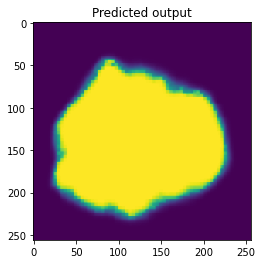

In [16]:
#sample predicted output
plt.title("Predicted output")
plt.imshow(y_pred[10])

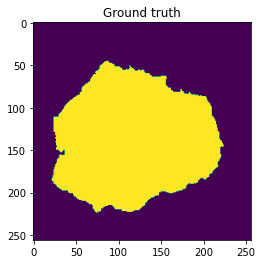

In [17]:
#sample ground truth
plt.title("Ground truth")
plt.imshow(y_test[10])

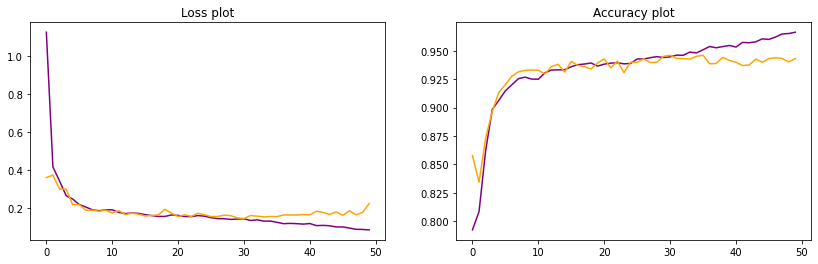

In [18]:
#visualising result curves
fig, axs = plt.subplots(1, 2, figsize=(14, 4))
axs[0].set_title("Loss plot")
axs[0].plot(moel_result.history['loss'], color='purple', label='train')
axs[0].plot(moel_result.history['val_loss'], color='orange', label='test')
axs[1].set_title("Accuracy plot")
axs[1].plot(moel_result.history['accuracy'], color='purple', label='train')
axs[1].plot(moel_result.history['val_accuracy'], color='orange', label='test')